This kernel gets 0.854 on Public LB and takes 16666 to run (both training and prediction). The model's performance can be definitely be improved by using some other tricks, one obvious way is to use KFold Cross Validation. You can train with lovasz loss to improve it further. I wanted to keep the kernel simple and run it within time limit, so it is a no frills models.
I am really thankful to the kaggle community for sharing their insights. I am thankful to kaggle for providing
GPUs and allowing multiple GPU Kernels in parallel. I dont' have access tp a good GPU so  I wouldn't have been able to experiment without these kernels.

The major highlights of the kernel are:
1.  The Encoder and Decoder Architecture
In the competition, everyone seems to be using ResNet34 encoder.
Keras doesn't provide pre-trained model weights for ResNet34. And kaggle didn't 
support pytorch v0.4 until recently. So, i had to look for other ways..
I experimented with all the pretrained models with different decoder architectures.
After lots of interesting experiments, I found that pretrained Xception model with ResNet decoder works best.
2. Use of Pseudo-Labelling.
After reaching 0.83+, my models started overfitting on the training set.
So, i took multiple models using different encoder architecture and found 
predictions in the test set that are common for every model.
For example, if three different models predict nearly the same mask on the 
test set, its highly likely the predicted mask is correct. 
In this way i generated two types of masks no-salt masks and some-salt
masks.I used these masks while training.
In the train set nearly 0.39% images don't have mask. I maintained this ratio
while using these masks for training (0.39*6000=2340)
3. Using normalized Gradient optimizer
The basic idea is to normalize each layer of the mini-batch stochastic gradient.
It has been shown that the normalized gradient methods having constant step size with occasionally decay, such as SGD with momentum,
have better performance in the deep convolution neural networks, than optimizers with adaptive step sizes likt Adam.
This optimizer was very useful for training my network. Normal SGD takes a very long time to converge.
4. Stochastic Weight Averaging (SWA)
It has been shown in recent paper that SWA finds much broader optima than SGD. I got a boost of around 0.003 with SWA.
It is extremely easy to implement and has very little computational overhead !!


# Some Useful Links

Useful Keras Implementations

Titu1994 github repo - https://github.com/titu1994

Kaggle Kernels 

Jack (Jiaxin) Shao: https://www.kaggle.com/shaojiaxin/u-net-with-simple-resnet-blocks-v2-new-loss

Bruno G. do Amaral: https://www.kaggle.com/bguberfain/elastic-transform-for-data-augmentation

Peter Hönigschmid: https://www.kaggle.com/phoenigs/u-net-dropout-augmentation-stratification

Juan C EsquivelTGS: https://www.kaggle.com/jcesquiveld/tgs-vanilla-u-net-with-simple-augmentation

NPHard: https://www.kaggle.com/meaninglesslives/using-resnet50-pretrained-model-in-keras

Kaggle Discussions

https://www.kaggle.com/c/tgs-salt-identification-challenge/discussion/64875

https://www.kaggle.com/c/tgs-salt-identification-challenge/discussion/66568

https://www.kaggle.com/c/tgs-salt-identification-challenge/discussion/64093

# Loading Libraries

In [ ]:
import numpy as np
import pandas as pd
import gc
import keras

import matplotlib.pyplot as plt
plt.style.use('seaborn-white')
import seaborn as sns
sns.set_style("white")

from sklearn.model_selection import train_test_split

from skimage.transform import resize
import tensorflow as tf
import keras.backend as K
from keras.losses import binary_crossentropy

from keras.preprocessing.image import load_img
from keras import Model
from keras.callbacks import  ModelCheckpoint
from keras.layers import Input, Conv2D, Conv2DTranspose, MaxPooling2D, concatenate, Dropout,BatchNormalization
from keras.layers import Conv2D, Concatenate, MaxPooling2D
from keras.layers import UpSampling2D, Dropout, BatchNormalization
from tqdm import tqdm_notebook
from keras import initializers
from keras import regularizers
from keras import constraints
from keras.utils import conv_utils
from keras.utils.data_utils import get_file
from keras.engine.topology import get_source_inputs
from keras.engine import InputSpec
from keras import backend as K
from keras.layers import LeakyReLU
from keras.layers import ZeroPadding2D
from keras.losses import binary_crossentropy
import keras.callbacks as callbacks
from keras.callbacks import Callback
from keras.applications.xception import Xception
from keras.layers import multiply


from keras import optimizers
from keras.legacy import interfaces
from keras.utils.generic_utils import get_custom_objects

from keras.engine.topology import Input
from keras.engine.training import Model
from keras.layers.convolutional import Conv2D, UpSampling2D, Conv2DTranspose
from keras.layers.core import Activation, SpatialDropout2D
from keras.layers.merge import concatenate
from keras.layers.normalization import BatchNormalization
from keras.layers.pooling import MaxPooling2D
from keras.layers import Input,Dropout,BatchNormalization,Activation,Add
from keras.regularizers import l2
from keras.layers.core import Dense, Lambda
from keras.layers.merge import concatenate, add
from keras.layers import GlobalAveragePooling2D, Reshape, Dense, multiply, Permute
from keras.optimizers import SGD

# Params and helpers

In [ ]:
img_size_ori = 101
img_size_target = 128

def upsample(img):
    if img_size_ori == img_size_target:
        return img
    return resize(img, (img_size_target, img_size_target), mode='constant', preserve_range=True)
    
def downsample(img):
    if img_size_ori == img_size_target:
        return img
    return resize(img, (img_size_ori, img_size_ori), mode='constant', preserve_range=True)

# Loading of training/testing ids and depths

In [ ]:
train_df = pd.read_csv("../input/tgs-salt-identification-challenge/train.csv", index_col="id", usecols=[0])
val_ids = pd.read_csv('../input/validation-ids/validation_ids.csv')
train_df = train_df.drop(val_ids.iloc[:,0].values)

no_salt_ids =  pd.read_csv("../input/pseudolabel-gen/no_salt_ids.csv", index_col="id", usecols=[0])
no_salt_ids = no_salt_ids.sample(2340)
some_salt_ids =  pd.read_csv("../input/pseudolabel-gen/some_salt_ids.csv", index_col="id")
some_salt_ids = some_salt_ids.sample(3660)

depths_df = pd.read_csv("../input/tgs-salt-identification-challenge/depths.csv", index_col="id")
train_df = train_df.join(depths_df)
test_df = depths_df[~depths_df.index.isin(train_df.index)]

# Read images and masks
Load the images and masks into the DataFrame and divide the pixel values by 255.

In [ ]:
train_df["images"] = [np.array(load_img("../input/tgs-salt-identification-challenge/train/images/{}.png".format(idx), grayscale=True)) / 255 for idx in tqdm_notebook(train_df.index)]
train_df["masks"] = [np.array(load_img("../input/tgs-salt-identification-challenge/train/masks/{}.png".format(idx), grayscale=True)) / 255 for idx in tqdm_notebook(train_df.index)]

In [ ]:
def rle_decode(rle_mask):
    '''
    rle_mask: run-length as string formated (start length)
    shape: (height,width) of array to return 
    Returns numpy array, 1 - mask, 0 - background

    '''
    if str(rle_mask)==str(np.nan):
        return np.zeros((101,101))
    s = rle_mask.split()
    starts, lengths = [np.asarray(x, dtype=int) for x in (s[0:][::2], s[1:][::2])]
    starts -= 1
    ends = starts + lengths
    img = np.zeros(101*101, dtype=np.uint8)
    for lo, hi in zip(starts, ends):
        img[lo:hi] = 1
    return img.reshape(101,101)

# Generating Pseudo Labels

No-Salt images

In [ ]:
train_df_temp = pd.DataFrame()
train_df_temp['id'] = no_salt_ids.index
train_df_temp = train_df_temp.set_index('id')
train_df_temp = train_df_temp.join(depths_df)
train_df_temp["images"] = [np.array(load_img("../input/tgs-salt-identification-challenge/test/images/{}.png".format(idx), grayscale=True)) / 255 for idx in tqdm_notebook(no_salt_ids.index)]
train_df_temp["masks"] = [np.zeros((img_size_ori,img_size_ori)) for idx in tqdm_notebook(no_salt_ids.index)]
train_df = train_df.append(train_df_temp)
del train_df_temp

Some Salt images

In [ ]:
train_df_temp = pd.DataFrame()
train_df_temp['id'] = some_salt_ids.index
train_df_temp = train_df_temp.set_index('id')
train_df_temp = train_df_temp.join(depths_df)
train_df_temp["images"] = [np.array(load_img("../input/tgs-salt-identification-challenge/test/images/{}.png".format(idx), grayscale=True)) / 255 for idx in tqdm_notebook(some_salt_ids.index)]
train_df_temp["masks"] = [np.fliplr(np.rot90(rle_decode(some_salt_ids.loc[idx,'rle_mask']),-1)) for idx in tqdm_notebook(some_salt_ids.index)]
train_df = train_df.append(train_df_temp)
del train_df_temp
gc.collect()

# Visualizing the class coverage

In [ ]:
train_df["coverage"] = train_df.masks.map(np.sum) / pow(img_size_ori, 2)
def cov_to_class(val):    
    for i in range(0, 11):
        if val * 10 <= i :
            return i
        
train_df["coverage_class"] = train_df.coverage.map(cov_to_class)

In [ ]:
fig, axs = plt.subplots(1, 2, figsize=(15,5))
sns.distplot(train_df.coverage, kde=False, ax=axs[0])
sns.distplot(train_df.coverage_class, bins=10, kde=False, ax=axs[1])
plt.suptitle("Salt coverage")
axs[0].set_xlabel("Coverage")
axs[1].set_xlabel("Coverage class")

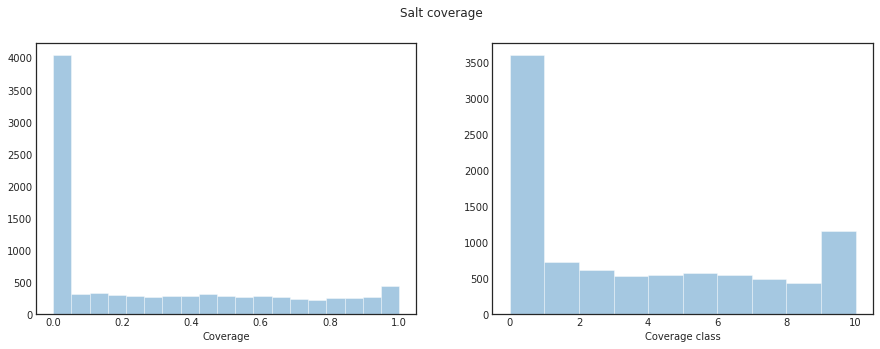

# Loading Validation Set

I have fixed the validation set for all my experiments. This allows me to easily compare different model performance.

In [ ]:
ids_valid = val_ids.iloc[:,0].values
temp_df = pd.DataFrame()
temp_df["images"] = [np.array(load_img("../input/tgs-salt-identification-challenge/train/images/{}.png".format(idx), grayscale=True)) / 255 for idx in tqdm_notebook(ids_valid)]
temp_df["masks"] = [np.array(load_img("../input/tgs-salt-identification-challenge/train/masks/{}.png".format(idx), grayscale=True)) / 255 for idx in tqdm_notebook(ids_valid)]
x_valid = np.array(temp_df.images.map(upsample).tolist()).reshape(-1, img_size_target, img_size_target, 1)
y_valid = np.array(temp_df.masks.map(upsample).tolist()).reshape(-1, img_size_target, img_size_target, 1)
del temp_df
gc.collect()

In [ ]:
ids_train,x_train,y_train = train_df.index.values,\
    np.array(train_df.images.map(upsample).tolist()).reshape(-1, img_size_target, img_size_target, 1), \
    np.array(train_df.masks.map(upsample).tolist()).reshape(-1, img_size_target, img_size_target, 1)

# Calculating IOU

In [ ]:
# https://www.kaggle.com/cpmpml/fast-iou-metric-in-numpy-and-tensorflow
def get_iou_vector(A, B):
    # Numpy version    
    batch_size = A.shape[0]
    metric = 0.0
    for batch in range(batch_size):
        t, p = A[batch], B[batch]
        true = np.sum(t)
        pred = np.sum(p)
        
        # deal with empty mask first
        if true == 0:
            metric += (pred == 0)
            continue
        
        # non empty mask case.  Union is never empty 
        # hence it is safe to divide by its number of pixels
        intersection = np.sum(t * p)
        union = true + pred - intersection
        iou = intersection / union
        
        # iou metrric is a stepwise approximation of the real iou over 0.5
        iou = np.floor(max(0, (iou - 0.45)*20)) / 10
        
        metric += iou
        
    # teake the average over all images in batch
    metric /= batch_size
    return metric


def my_iou_metric(label, pred):
    # Tensorflow version
    return tf.py_func(get_iou_vector, [label, pred > 0.5], tf.float64)

In [ ]:
def dice_coef(y_true, y_pred):
    y_true_f = K.flatten(y_true)
    y_pred = K.cast(y_pred, 'float32')
    y_pred_f = K.cast(K.greater(K.flatten(y_pred), 0.5), 'float32')
    intersection = y_true_f * y_pred_f
    score = 2. * K.sum(intersection) / (K.sum(y_true_f) + K.sum(y_pred_f))
    return score

def dice_loss(y_true, y_pred):
    smooth = 1.
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = y_true_f * y_pred_f
    score = (2. * K.sum(intersection) + smooth) / (K.sum(y_true_f) + K.sum(y_pred_f) + smooth)
    return 1. - score

def bce_dice_loss(y_true, y_pred):
    return binary_crossentropy(y_true, y_pred) + dice_loss(y_true, y_pred)

def bce_logdice_loss(y_true, y_pred):
    return binary_crossentropy(y_true, y_pred) - K.log(1. - dice_loss(y_true, y_pred))

In [ ]:
class SnapshotCallbackBuilder:
    def __init__(self, nb_epochs, nb_snapshots, init_lr=0.1):
        self.T = nb_epochs
        self.M = nb_snapshots
        self.alpha_zero = init_lr

    def get_callbacks(self, model_prefix='Model'):

        callback_list = [
            callbacks.ModelCheckpoint("./keras.model",monitor='val_my_iou_metric', 
                                   mode = 'max', save_best_only=True, verbose=1),
            swa,
            callbacks.LearningRateScheduler(schedule=self._cosine_anneal_schedule)
        ]

        return callback_list

    def _cosine_anneal_schedule(self, t):
        cos_inner = np.pi * (t % (self.T // self.M))  # t - 1 is used when t has 1-based indexing.
        cos_inner /= self.T // self.M
        cos_out = np.cos(cos_inner) + 1
        return float(self.alpha_zero / 2 * cos_out)

Useful Model Blocks

In [ ]:
def convolution_block(x, filters, size, strides=(1,1), padding='same', activation=True):
    x = Conv2D(filters, size, strides=strides, padding=padding)(x)
    x = BatchNormalization()(x)
    if activation == True:
        x = LeakyReLU(alpha=0.1)(x)
    return x

def residual_block(blockInput, num_filters=16):
    x = LeakyReLU(alpha=0.1)(blockInput)
    x = BatchNormalization()(x)
    blockInput = BatchNormalization()(blockInput)
    x = convolution_block(x, num_filters, (3,3) )
    x = convolution_block(x, num_filters, (3,3), activation=False)
    x = Add()([x, blockInput])
    return x

# Defining UXception Model

As mentioned above, this model uses pretrained Xception model as encoder. It uses Residual blocks in the decoder part,

In [ ]:
def UXception(input_shape=(None, None, 3)):

    backbone = Xception(input_shape=input_shape,weights='imagenet',include_top=False)
    input = backbone.input
    start_neurons = 16

    conv4 = backbone.layers[121].output
    conv4 = LeakyReLU(alpha=0.1)(conv4)
    pool4 = MaxPooling2D((2, 2))(conv4)
    pool4 = Dropout(0.1)(pool4)
    
     # Middle
    convm = Conv2D(start_neurons * 32, (3, 3), activation=None, padding="same")(pool4)
    convm = residual_block(convm,start_neurons * 32)
    convm = residual_block(convm,start_neurons * 32)
    convm = LeakyReLU(alpha=0.1)(convm)
    
    # 10 -> 20
    deconv4 = Conv2DTranspose(start_neurons * 16, (3, 3), strides=(2, 2), padding="same")(convm)
    uconv4 = concatenate([deconv4, conv4])
    uconv4 = Dropout(0.1)(uconv4)
    
    uconv4 = Conv2D(start_neurons * 16, (3, 3), activation=None, padding="same")(uconv4)
    uconv4 = residual_block(uconv4,start_neurons * 16)
    uconv4 = residual_block(uconv4,start_neurons * 16)
    uconv4 = LeakyReLU(alpha=0.1)(uconv4)
    
    # 10 -> 20
    deconv3 = Conv2DTranspose(start_neurons * 8, (3, 3), strides=(2, 2), padding="same")(uconv4)
    conv3 = backbone.layers[31].output
    uconv3 = concatenate([deconv3, conv3])    
    uconv3 = Dropout(0.1)(uconv3)
    
    uconv3 = Conv2D(start_neurons * 8, (3, 3), activation=None, padding="same")(uconv3)
    uconv3 = residual_block(uconv3,start_neurons * 8)
    uconv3 = residual_block(uconv3,start_neurons * 8)
    uconv3 = LeakyReLU(alpha=0.1)(uconv3)

    # 20 -> 40
    deconv2 = Conv2DTranspose(start_neurons * 4, (3, 3), strides=(2, 2), padding="same")(uconv3)
    conv2 = backbone.layers[21].output
    conv2 = ZeroPadding2D(((1,0),(1,0)))(conv2)
    uconv2 = concatenate([deconv2, conv2])
        
    uconv2 = Dropout(0.1)(uconv2)
    uconv2 = Conv2D(start_neurons * 4, (3, 3), activation=None, padding="same")(uconv2)
    uconv2 = residual_block(uconv2,start_neurons * 4)
    uconv2 = residual_block(uconv2,start_neurons * 4)
    uconv2 = LeakyReLU(alpha=0.1)(uconv2)
    
    # 40 -> 80
    deconv1 = Conv2DTranspose(start_neurons * 2, (3, 3), strides=(2, 2), padding="same")(uconv2)
    conv1 = backbone.layers[11].output
    conv1 = ZeroPadding2D(((3,0),(3,0)))(conv1)
    uconv1 = concatenate([deconv1, conv1])
    
    uconv1 = Dropout(0.1)(uconv1)
    uconv1 = Conv2D(start_neurons * 2, (3, 3), activation=None, padding="same")(uconv1)
    uconv1 = residual_block(uconv1,start_neurons * 2)
    uconv1 = residual_block(uconv1,start_neurons * 2)
    uconv1 = LeakyReLU(alpha=0.1)(uconv1)
    
    
    # 80 -> 160
    uconv0 = Conv2DTranspose(start_neurons * 1, (3, 3), strides=(2, 2), padding="same")(uconv1)   
    uconv0 = Dropout(0.1)(uconv0)
    uconv0 = Conv2D(start_neurons * 1, (3, 3), activation=None, padding="same")(uconv0)
    uconv0 = residual_block(uconv0,start_neurons * 1)
    uconv0 = residual_block(uconv0,start_neurons * 1)
    uconv0 = LeakyReLU(alpha=0.1)(uconv0)
    
    uconv0 = Dropout(0.1/2)(uconv0)
    output_layer = Conv2D(1, (1,1), padding="same", activation="sigmoid")(uconv0)    
    
    model = Model(input, output_layer)
    model.name = 'u-xception'

    return model

In [ ]:
K.clear_session()
model = UXception(input_shape=(img_size_target,img_size_target,3))

# Defining the Normalized Gradient SGD Optimizer

This leads to much faster converagnce as compare to normal SGD.

In [ ]:
# https://github.com/titu1994/keras-normalized-optimizers
# Computes the L-2 norm of the gradient.
def l2_norm(grad):
    norm = K.sqrt(K.sum(K.square(grad))) + K.epsilon()
    return norm

class OptimizerWrapper(optimizers.Optimizer):

    def __init__(self, optimizer):     
        
        self.optimizer = optimizers.get(optimizer)

        # patch the `get_gradients` call
        self._optimizer_get_gradients = self.optimizer.get_gradients

    def get_gradients(self, loss, params):      
        grads = self._optimizer_get_gradients(loss, params)
        return grads

    @interfaces.legacy_get_updates_support
    def get_updates(self, loss, params):
        # monkey patch `get_gradients`
        self.optimizer.get_gradients = self.get_gradients

        # get the updates
        self.optimizer.get_updates(loss, params)

        # undo monkey patch
        self.optimizer.get_gradients = self._optimizer_get_gradients

        return self.updates

    def set_weights(self, weights):       
        self.optimizer.set_weights(weights)

    def get_weights(self):        
        return self.optimizer.get_weights()

    def get_config(self):       
        # properties of NormalizedOptimizer
        config = {'optimizer_name': self.optimizer.__class__.__name__.lower()}

        # optimizer config
        optimizer_config = {'optimizer_config': self.optimizer.get_config()}
        return dict(list(optimizer_config.items()) + list(config.items()))

    @property
    def weights(self):
        return self.optimizer.weights

    @property
    def updates(self):
        return self.optimizer.updates

    @classmethod
    def from_config(cls, config):
        raise NotImplementedError

    @classmethod
    def set_normalization_function(cls, name, func):
        global _NORMS
        _NORMS[name] = func

    @classmethod
    def get_normalization_functions(cls):        
        global _NORMS
        return sorted(list(_NORMS.keys()))


class NormalizedOptimizer(OptimizerWrapper):

    def __init__(self, optimizer, normalization='l2'):       
        super(NormalizedOptimizer, self).__init__(optimizer)

        if normalization not in _NORMS:
            raise ValueError('`normalization` must be one of %s.\n' 
                             'Provided was "%s".' % (str(sorted(list(_NORMS.keys()))), normalization))

        self.normalization = normalization
        self.normalization_fn = _NORMS[normalization]
        self.lr = K.variable(1e-3, name='lr')

    def get_gradients(self, loss, params):       
        grads = super(NormalizedOptimizer, self).get_gradients(loss, params)
        grads = [grad / self.normalization_fn(grad) for grad in grads]
        return grads

    def get_config(self):        
        # properties of NormalizedOptimizer
        config = {'normalization': self.normalization}

        # optimizer config
        base_config = super(NormalizedOptimizer, self).get_config()
        return dict(list(base_config.items()) + list(config.items()))

    @classmethod
    def from_config(cls, config):       
        optimizer_config = {'class_name': config['optimizer_name'],
                            'config': config['optimizer_config']}

        optimizer = optimizers.get(optimizer_config)
        normalization = config['normalization']

        return cls(optimizer, normalization=normalization)


_NORMS = {
    'l2': l2_norm,
}

# register this optimizer to the global custom objects when it is imported
get_custom_objects().update({'NormalizedOptimizer': NormalizedOptimizer})

In [ ]:
class SWA(keras.callbacks.Callback):
    
    def __init__(self, filepath, swa_epoch):
        super(SWA, self).__init__()
        self.filepath = filepath
        self.swa_epoch = swa_epoch 
    
    def on_train_begin(self, logs=None):
        self.nb_epoch = self.params['epochs']
        print('Stochastic weight averaging selected for last {} epochs.'
              .format(self.nb_epoch - self.swa_epoch))
        
    def on_epoch_end(self, epoch, logs=None):
        
        if epoch == self.swa_epoch:
            self.swa_weights = self.model.get_weights()
            
        elif epoch > self.swa_epoch:    
            for i in range(len(self.swa_weights)):
                self.swa_weights[i] = (self.swa_weights[i] * 
                    (epoch - self.swa_epoch) + self.model.get_weights()[i])/((epoch - self.swa_epoch)  + 1)  

        else:
            pass
        
    def on_train_end(self, logs=None):
        self.model.set_weights(self.swa_weights)
        print('Final model parameters set to stochastic weight average.')
        self.model.save_weights(self.filepath)
        print('Final stochastic averaged weights saved to file.')

In [ ]:
sgd = SGD(0.01, momentum=0.9, nesterov=True)
sgd = NormalizedOptimizer(sgd, normalization='l2')

In [ ]:
model.compile(loss=bce_dice_loss, optimizer=sgd, metrics=[my_iou_metric])

# Augmentation using fliplr

I only augment the images in training set.  I repeat the image in to get 3 channels which is required for using pretrained imagenet models.

In [ ]:
x_train = np.append(x_train, [np.fliplr(x) for x in x_train[0:3200]], axis=0)
y_train = np.append(y_train, [np.fliplr(x) for x in y_train[0:3200]], axis=0)
x_train = np.repeat(x_train,3,axis=3)
x_valid = np.repeat(x_valid,3,axis=3)

# Training the Model

In [ ]:
epochs = 40
snapshot = SnapshotCallbackBuilder(nb_epochs=epochs,nb_snapshots=1,init_lr=1e-3)
batch_size = 32
swa = SWA('./keras_swa.model',35)
history = model.fit(x_train, y_train,
                    validation_data=[x_valid, y_valid], 
                    epochs=epochs,
                    batch_size=batch_size,
                    callbacks=snapshot.get_callbacks(),shuffle=True,verbose=2)

In [ ]:
plt.plot(history.history['my_iou_metric'][1:])
plt.plot(history.history['val_my_iou_metric'][1:])
plt.title('model iou metric')
plt.ylabel('val_my_iou_metric')
plt.xlabel('epoch')
plt.legend(['train','Validation'], loc='upper left')
plt.show()

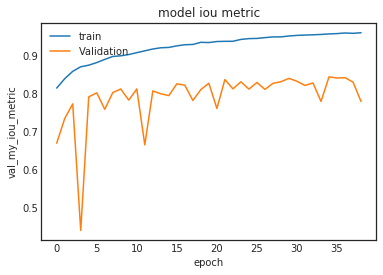

In [ ]:
del ids_train, x_train, y_train,some_salt_ids,depths_df
gc.collect()

In [ ]:
# Load best model
try:
    print('using swa weight model')
    model.load_weights('./keras_swa.model')
except:
    model.load_weights('./keras.model')

# Predict the validation set to do a sanity check
Again plot some sample images including the predictions.

In [ ]:
def predict_result(model,x_test,img_size_target,batch_size): # predict both orginal and reflect x
    x_test_reflect =  np.array([np.fliplr(x) for x in x_test])
    preds_test1 = model.predict([x_test],batch_size=batch_size).reshape(-1, img_size_target, img_size_target)
    preds_test2_refect = model.predict([x_test_reflect],batch_size=batch_size).reshape(-1, img_size_target, img_size_target)
    preds_test2 = np.array([ np.fliplr(x) for x in preds_test2_refect] )
    preds_avg = (preds_test1 +preds_test2)/2
    return preds_avg

In [ ]:
preds_valid = predict_result(model,x_valid,img_size_target,batch_size)
preds_valid = np.array([downsample(x) for x in preds_valid])
y_valid_ori = np.array([downsample(x) for x in y_valid])

In [ ]:
max_images = 60
grid_width = 15
grid_height = int(max_images / grid_width)
fig, axs = plt.subplots(grid_height, grid_width, figsize=(grid_width, grid_height))
for i, idx in enumerate(ids_valid[:max_images]):
    img = x_valid[i]
    mask = y_valid[i].squeeze()
    pred = preds_valid[i]
    ax = axs[int(i / grid_width), i % grid_width]
    ax.imshow(img, cmap="Greys")
    ax.imshow(mask, alpha=0.3, cmap="Greens")
    ax.imshow(pred, alpha=0.3, cmap="OrRd")
plt.suptitle("Green: salt, Red: prediction. Top-left: coverage class, top-right: salt coverage, bottom-left: depth")

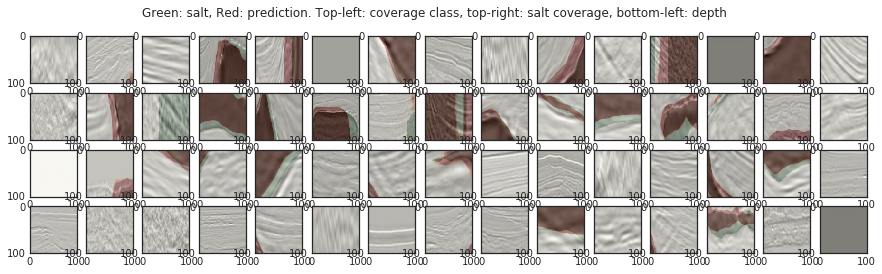

# Scoring
Score the model and do a threshold optimization by the best IoU.

In [ ]:
# src: https://www.kaggle.com/aglotero/another-iou-metric
def iou_metric(y_true_in, y_pred_in, print_table=False):
    labels = y_true_in
    y_pred = y_pred_in
    
    true_objects = 2
    pred_objects = 2

    intersection = np.histogram2d(labels.flatten(), y_pred.flatten(), bins=(true_objects, pred_objects))[0]

    # Compute areas (needed for finding the union between all objects)
    area_true = np.histogram(labels, bins = true_objects)[0]
    area_pred = np.histogram(y_pred, bins = pred_objects)[0]
    area_true = np.expand_dims(area_true, -1)
    area_pred = np.expand_dims(area_pred, 0)

    # Compute union
    union = area_true + area_pred - intersection

    # Exclude background from the analysis
    intersection = intersection[1:,1:]
    union = union[1:,1:]
    union[union == 0] = 1e-9

    # Compute the intersection over union
    iou = intersection / union

    # Precision helper function
    def precision_at(threshold, iou):
        matches = iou > threshold
        true_positives = np.sum(matches, axis=1) == 1   # Correct objects
        false_positives = np.sum(matches, axis=0) == 0  # Missed objects
        false_negatives = np.sum(matches, axis=1) == 0  # Extra objects
        tp, fp, fn = np.sum(true_positives), np.sum(false_positives), np.sum(false_negatives)
        return tp, fp, fn

    # Loop over IoU thresholds
    prec = []
    if print_table:
        print("Thresh\tTP\tFP\tFN\tPrec.")
    for t in np.arange(0.5, 1.0, 0.05):
        tp, fp, fn = precision_at(t, iou)
        if (tp + fp + fn) > 0:
            p = tp / (tp + fp + fn)
        else:
            p = 0
        if print_table:
            print("{:1.3f}\t{}\t{}\t{}\t{:1.3f}".format(t, tp, fp, fn, p))
        prec.append(p)
    
    if print_table:
        print("AP\t-\t-\t-\t{:1.3f}".format(np.mean(prec)))
    return np.mean(prec)

def iou_metric_batch(y_true_in, y_pred_in):
    batch_size = y_true_in.shape[0]
    metric = []
    for batch in range(batch_size):
        value = iou_metric(y_true_in[batch], y_pred_in[batch])
        metric.append(value)
    return np.mean(metric)

In [ ]:
## Scoring for last model
thresholds = np.linspace(0.3, 0.7, 31)
ious = np.array([iou_metric_batch(y_valid_ori, np.int32(preds_valid > threshold)) for threshold in tqdm_notebook(thresholds)])

In [ ]:
threshold_best_index = np.argmax(ious) 
iou_best = ious[threshold_best_index]
threshold_best = thresholds[threshold_best_index]

plt.plot(thresholds, ious)
plt.plot(threshold_best, iou_best, "xr", label="Best threshold")
plt.xlabel("Threshold")
plt.ylabel("IoU")
plt.title("Threshold vs IoU ({}, {})".format(threshold_best, iou_best))
plt.legend()

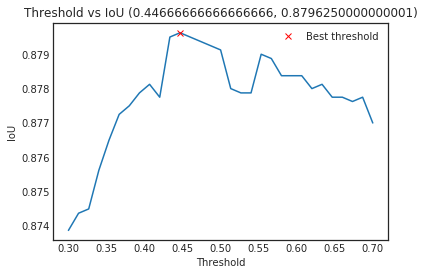

# Another sanity check with adjusted threshold
Again some sample images with the adjusted threshold.

In [ ]:
max_images = 60
grid_width = 15
grid_height = int(max_images / grid_width)
fig, axs = plt.subplots(grid_height, grid_width, figsize=(grid_width, grid_height))
for i, idx in enumerate(ids_valid[:max_images]):
    img = x_valid[i]
    mask = y_valid[i].squeeze()
    pred = preds_valid[i]
    ax = axs[int(i / grid_width), i % grid_width]
    ax.imshow(img, cmap="Greys")
    ax.imshow(mask, alpha=0.3, cmap="Greens")
    ax.imshow(np.array(np.round(pred > threshold_best), dtype=np.float32), alpha=0.3, cmap="OrRd")
plt.suptitle("Green: salt, Red: prediction. Top-left: coverage class, top-right: salt coverage, bottom-left: depth")

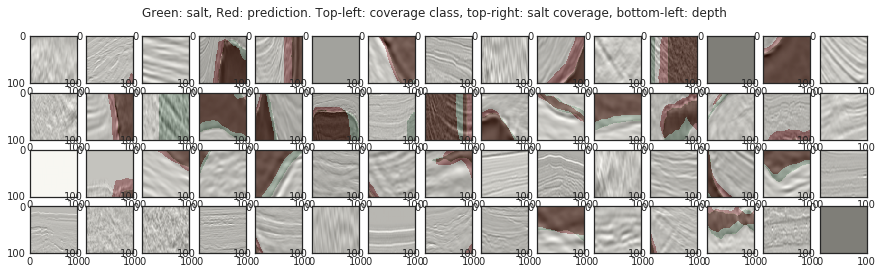

In [ ]:
del x_valid, y_valid,preds_valid,y_valid_ori,train_df
gc.collect()

# Test Set Prediction

In [ ]:
train_df = pd.read_csv("../input/tgs-salt-identification-challenge/train.csv", index_col="id", usecols=[0])
depths_df = pd.read_csv("../input/tgs-salt-identification-challenge/depths.csv", index_col="id")
train_df = train_df.join(depths_df)
test_df = depths_df[~depths_df.index.isin(train_df.index)]

In [ ]:
batch_size = 500
preds_test = []
i = 0
while i < test_df.shape[0]:
    index_val = test_df.index[i:i+batch_size]
#     depth_val = test_df.z[i:i+batch_size]
    x_test = np.array([upsample(np.array(load_img("../input/tgs-salt-identification-challenge/test/images/{}.png".format(idx), grayscale=True))) / 255 for idx in (index_val)]).reshape(-1, img_size_target, img_size_target, 1)
    x_test = np.repeat(x_test,3,axis=3)
    preds_test_temp = predict_result(model,x_test,img_size_target,32)
    if i==0:
        preds_test = preds_test_temp
    else:
        preds_test = np.concatenate([preds_test,preds_test_temp],axis=0)
    if i%2000==0:
        print('Images Processed:',i)
    i += batch_size    
print('Done!')

# Some Test Set Predictions

In [ ]:
max_images = 60
grid_width = 15
grid_height = int(max_images / grid_width)
fig, axs = plt.subplots(grid_height, grid_width, figsize=(grid_width, grid_height))
for i, idx in enumerate(index_val[:max_images]):
    img = x_test[i]
    pred = preds_test[i]
    ax = axs[int(i / grid_width), i % grid_width]
    ax.imshow(img, cmap="Greys")
    ax.imshow(np.array(np.round(pred > threshold_best), dtype=np.float32), alpha=0.3, cmap="OrRd")

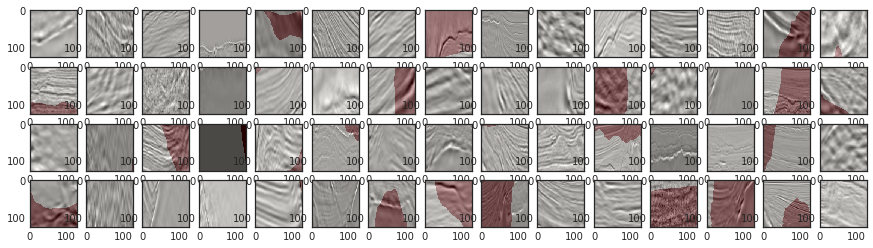

In [ ]:
"""
used for converting the decoded image to rle mask
Fast compared to previous one
"""
def rle_encode(im):
    '''
    im: numpy array, 1 - mask, 0 - background
    Returns run length as string formated
    '''
    pixels = im.flatten(order = 'F')
    pixels = np.concatenate([[0], pixels, [0]])
    runs = np.where(pixels[1:] != pixels[:-1])[0] + 1
    runs[1::2] -= runs[::2]
    return ' '.join(str(x) for x in runs)

In [ ]:
import time
t1 = time.time()
pred_dict = {idx: rle_encode(np.round(downsample(preds_test[i]) > threshold_best)) for i, idx in enumerate(tqdm_notebook(test_df.index.values))}
t2 = time.time()

print(f"Usedtime = {t2-t1} s")

In [ ]:
sub = pd.DataFrame.from_dict(pred_dict,orient='index')
sub.index.names = ['id']
sub.columns = ['rle_mask']
sub.to_csv('swa_xce_submission.csv')